In [7]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import numpy as np


In [6]:
%pip install --upgrade statsmodels


  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\JCheung1\\Anaconda3\\Lib\\site-packages\\~tatsmodels\\nonparametric\\linbin.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
df = pd.read_csv(os.getcwd() + '\\data_files\\2021-06\\master_ami.csv', index_col='USAGE_DATE', parse_dates=True)
df['Year'] = df.index.year
df['Month'] = df.index.month
df['WD'] = df.index.weekday

## 2.1-2.9 Seasonality plots


C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


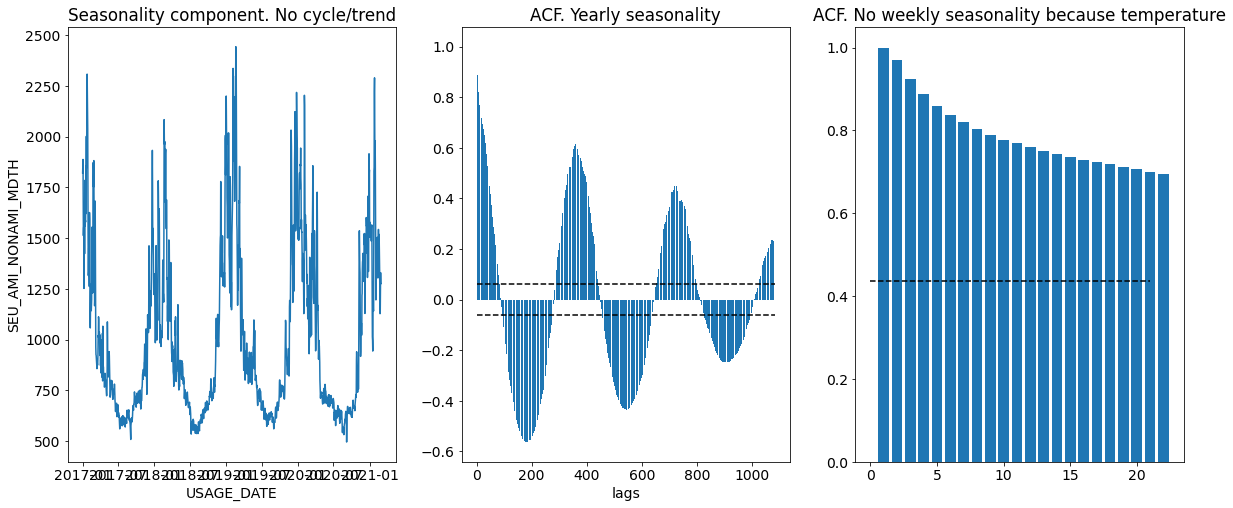

White-noise if 95% of data lies within dashed lines


In [108]:
plt.figure(figsize=(20,8))
plt.rcParams.update({'font.size':14})
plt.subplot(1,3,1)
sns.lineplot(x=df.index, y='SEU_AMI_NONAMI_MDTH', data=df)
plt.title('Seasonality component. No cycle/trend')

plt.subplot(1,3,2)
plt.bar(np.arange(1,1082), acf(df['SEU_AMI_NONAMI_MDTH'], nlags=1080))
plt.plot([0, 1082], [(2/np.sqrt(1080)), (2/np.sqrt(1080))], 'k--')
plt.plot([0, 1082], [-(2/np.sqrt(1080)), -(2/np.sqrt(1080))], 'k--')
plt.title('ACF. Yearly seasonality')
plt.xlabel('lags')


plt.subplot(1,3,3)
plt.bar(np.arange(1, 23), acf(df['SEU_AMI_NONAMI_MDTH'], nlags=21))
plt.plot([0, 21], [(2/np.sqrt(21)), (2/np.sqrt(21))], 'k--')
plt.title('ACF. No weekly seasonality because temperature')
plt.show()

print('White-noise if 95% of data lies within dashed lines')

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
sns.catplot(x='WD', y='SEU_AMI_NONAMI_MDTH', kind='bar', data=df)
plt.ylim([850, 1100])
plt.title('Weekday usage')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
sns.lineplot(x='WD', y='SEU_AMI_NONAMI_MDTH', hue='Month', data=df, palette='twilight', ci=None)
plt.title('Weekday usage x month')
plt.show()

In [ ]:
plt.figure(figsize=(100,8))
sns.catplot(x='Month', y='SEU_AMI_NONAMI_MDTH', hue='Year', kind='box', data=df)
plt.title('Monthly usage x year')
plt.show()

## 3.1 Simple forecasting methods


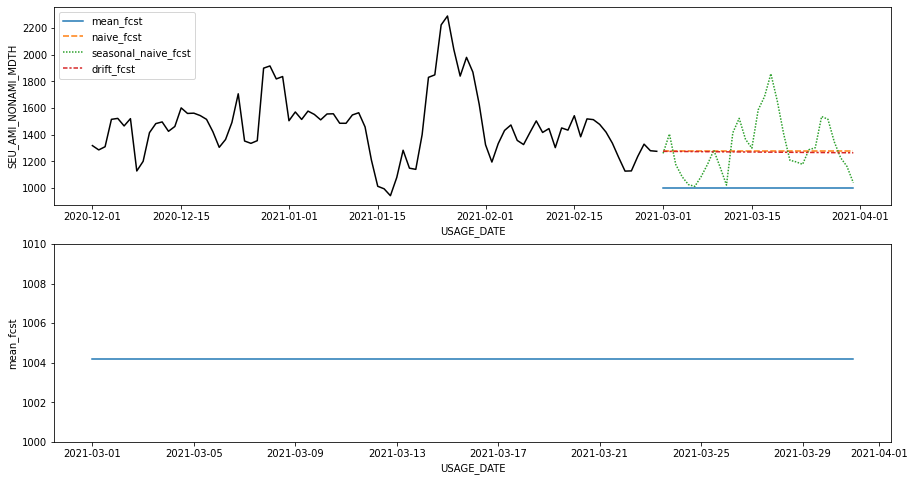

In [105]:
forecast_dates = pd.date_range(df.index.max() + pd.DateOffset(days=1),df.index.max() + pd.DateOffset(days=31),freq='d')
forecast_df = pd.DataFrame({'USAGE_DATE': forecast_dates}).set_index('USAGE_DATE')
# average method
forecast_df['mean_fcst'] = df['SEU_AMI_NONAMI_MDTH'].mean()
# naive/ random walkmethod
forecast_df['naive_fcst'] = df.loc[df.index.max(),'SEU_AMI_NONAMI_MDTH']
# seasonal naive
forecast_df['seasonal_naive_fcst'] = df.loc[forecast_df.index - pd.DateOffset(years=1), 'SEU_AMI_NONAMI_MDTH'].values
# drift 
drift_slope = (df.loc[df.index.max(),'SEU_AMI_NONAMI_MDTH'] - df.loc[df.index.min(),'SEU_AMI_NONAMI_MDTH']) / (len(df) - 1)
forecast_df['drift_fcst'] = df.loc[df.index.max(), 'SEU_AMI_NONAMI_MDTH'] + np.arange(1, len(forecast_df)+1) * drift_slope

plot_df = df[df.index > (df.index.max() - pd.DateOffset(days=90))]

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.lineplot(x=plot_df.index, y='SEU_AMI_NONAMI_MDTH', data=plot_df, color='k')
sns.lineplot(data=forecast_df)
plt.subplot(2,1,2)
h = np.arange(1, len(forecast_df)+1) 
forecast_df['mean_fcst_ci'] = 1.96 * np.sqrt(1 + (1/len(df)))
forecast_df['naive_fcst_ci'] = 1.96 * np.sqrt(h) 
forecast_df['seasonal_naive_fcst_ci'] = 1.96 * np.sqrt(((h-1)/365) + 1)
forecast_df['drift_fcst_ci'] = 1.96 * np.sqrt(h * (1+h/len(df)))
sns.lineplot(x=forecast_df.index, y='mean_fcst', ci='mean_fcst_ci', data=forecast_df)
plt.ylim([1000, 1010])
plt.show()

## 3.2 Transformations and adjustments

In [ ]:
# calendar adjustments
down_df = df.resample('2W').mean()
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.lineplot(x=df.index, y='SEU_AMI_NONAMI_MDTH', data=df)
plt.xlabel(''), plt.ylim([450, 2500]), plt.xticks([]), plt.title('Original')
plt.subplot(2,1,2)
sns.lineplot(x=down_df.index, y='SEU_AMI_NONAMI_MDTH', data=down_df)
plt.ylim([450, 2500]), plt.title('2W downsample')
plt.tight_layout(), plt.show()

In [ ]:
# population adjustments 
regions = ['SoCal', 'SD', 'SEU']
for x in regions:
    df[x + '_PER_CAPITA_MDTH'] = df[x + '_AMI_NONAMI_MDTH'] / df[x + '_CUST_COUNT']
    
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.lineplot(x=df.index, y='SEU_AMI_NONAMI_MDTH', data=df)
plt.xlabel(''), plt.xticks([]), plt.title('Original')
plt.subplot(2,1,2)
sns.lineplot(x=df.index, y='SEU_PER_CAPITA', data=df)
plt.title('Per Capita MDth')
plt.tight_layout(), plt.show()

## 3.3-3.4. Diagnostics | Evaluating Forecast Accuracy

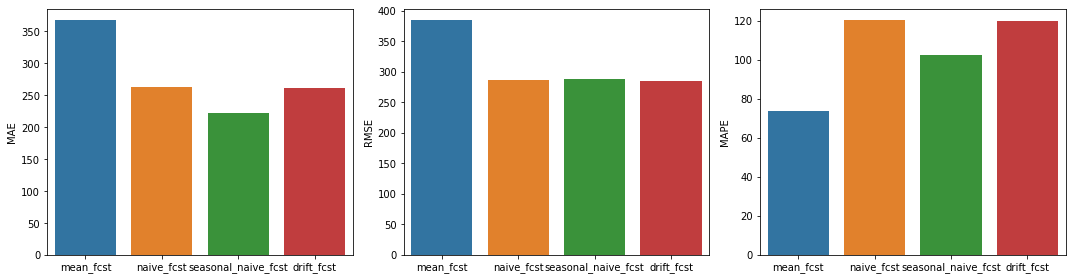

(None, None)

In [83]:
#split train|test set. 
train = df[df.index < pd.to_datetime('2/1/21')].copy()
test = df[df.index >= pd.to_datetime('2/1/21')].copy()

# forecast test set 
# average method
test.loc[:, 'mean_fcst'] = train['SEU_AMI_NONAMI_MDTH'].mean()
# naive/ random walkmethod
test.loc[:, 'naive_fcst'] = train.loc[train.index.max(),'SEU_AMI_NONAMI_MDTH']
# seasonal naive
test.loc[:, 'seasonal_naive_fcst'] = train.loc[test.index - pd.DateOffset(years=1), 'SEU_AMI_NONAMI_MDTH'].values
# drift 
drift_slope = (train.loc[train.index.max(),'SEU_AMI_NONAMI_MDTH'] - train.loc[train.index.min(),'SEU_AMI_NONAMI_MDTH']) / (len(train) - 1)
test.loc[:, 'drift_fcst'] = train.loc[train.index.max(), 'SEU_AMI_NONAMI_MDTH'] + np.arange(1, len(test)+1) * drift_slope

def evaluation_primer(df, true_column, forecast_column, plot=False): 
    df.loc[:, forecast_column + '_residuals'] = df[true_column] - df[forecast_column]
    df.loc[:, forecast_column + '_pct_error'] = 100* (df[forecast_column] / df[true_column])
    if plot:
        plt.figure(figsize=(15,8))
        plt.subplot(1,2,1) 
        sns.histplot(data=df, x=forecast_column + '_residuals')
        plt.title(round(df[forecast_column + '_residuals'].mean(),2))
        plt.subplot(1,2,2) 
        sns.lineplot(data=df, x=df.index, y=acf(df[forecast_column+'_residuals'], nlags=30))
        plt.plot([test.index.min(), test.index.max()], [(2/np.sqrt(30)), (2/np.sqrt(30))], 'k--')
        plt.plot([test.index.min(), test.index.max()], [(2/np.sqrt(30)), (2/np.sqrt(30))], 'k--')
        lb_test = sm.stats.acorr_ljungbox(df[forecast_column+'_residuals'], lags=[27])
        plt.title('LjungBox Test Q: ' + str(lb_test[0]) + ' p: ' + str(lb_test[1]))
        plt.show()
    return df

for models in [x for x in test.columns if '_fcst' in x]:
    test = evaluation_primer(test, true_column='SEU_AMI_NONAMI_MDTH', forecast_column=models, plot=False)
    
#evaluation for scaled (MAE and RMSE) along with percent error metrics (MAPE)
residual_cols = [x for x in test.columns if 'residuals' in x]
pct_cols = [x for x in test.columns if 'pct' in x]
MAE = test[residual_cols].apply(abs).mean()
RMSE = (test[residual_cols]**2).mean()**.5
MAPE = test[pct_cols].apply(abs).mean()

MAE.index = [x.split('_residuals')[0] for x in MAE.index]
RMSE.index = [x.split('_residuals')[0] for x in RMSE.index]
MAPE.index = [x.split('_pct')[0] for x in MAPE.index]

evaluation = pd.DataFrame({'MAE': MAE, 'RMSE':RMSE, 'MAPE':MAPE})
evaluation
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), sns.barplot(x=evaluation.index, y='MAE', data = evaluation)
plt.subplot(1,3,2), sns.barplot(x=evaluation.index, y='RMSE', data = evaluation)
plt.subplot(1,3,3), sns.barplot(x=evaluation.index, y='MAPE', data = evaluation)
plt.tight_layout(), plt.show()